<a href="https://colab.research.google.com/github/Giang2003/DSProjects/blob/main/StockProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADBE


In [ ]:
# Load data from csv file
data_adbe = pd.read_csv('ADBE.csv')
data_msft = pd.read_csv('MSFT.csv')
data_amzn = pd.read_csv('AMZN.csv')
data_nflx = pd.read_csv('NFLX.csv')

In [ ]:
data_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9158 entries, 0 to 9157
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            9158 non-null   object 
 1   Low             9158 non-null   float64
 2   Open            9158 non-null   float64
 3   Volume          9158 non-null   int64  
 4   High            9158 non-null   float64
 5   Close           9158 non-null   float64
 6   Adjusted Close  9158 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 501.0+ KB


In [ ]:
def prepare_data(company_data, window_size):
    X_data = []
    y_data = []

    # Only get the open price (replace index 2 if necessary)
    for i in range(1, len(company_data) - window_size - 1):
        first = company_data.iloc[i, 2]
        data_feature = []
        data_label = []

        # Get a window_size time frame for data feature
        for j in range(window_size):
            data_feature.append(company_data.iloc[i + j, 2])

        # Next value is the label (price of the next day) to be predicted
        data_label.append(company_data.iloc[i + window_size, 2])

        # Append new data sample (feature and label) to X_data and y_data
        X_data.append(np.array(data_feature).reshape(window_size, 1))
        y_data.append(np.array(data_label))

    return np.array(X_data), np.array(y_data)


In [ ]:
window_size = 30

In [ ]:
X_data, y_data = prepare_data(data_adbe, window_size)

In [ ]:
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

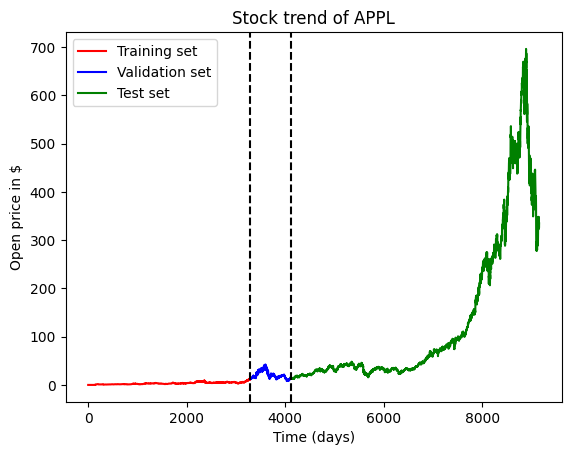

In [ ]:
# Visualize the training, validation and test set
df_plot = data_adbe['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of ADBE")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
def normalize_data(X_train, y_train, X_val, y_val):
    X_train_norm = X_train.copy()
    y_train_norm = y_train.copy()
    X_val_norm = X_val.copy()
    y_val_norm = y_val.copy()

    for i in range(len(X_train)):
        min_feature = np.min(X_train[i])
        max_feature = np.max(X_train[i])
        if max_feature != min_feature:
            X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
            y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

    for i in range(len(X_val)):
        min_feature = np.min(X_val[i])
        max_feature = np.max(X_val[i])
        if max_feature != min_feature:
            X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
            y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

    return X_train_norm, y_train_norm, X_val_norm, y_val_norm


In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5
12/12 [==============================] - 6s 260ms/step - loss: 0.5767 - mse: 0.5767 - val_loss: 0.1993 - val_mse: 0.1993
Epoch 2/5
12/12 [==============================] - 3s 291ms/step - loss: 0.1524 - mse: 0.1524 - val_loss: 0.1193 - val_mse: 0.1193
Epoch 3/5
12/12 [==============================] - 2s 200ms/step - loss: 0.1088 - mse: 0.1088 - val_loss: 0.1009 - val_mse: 0.1009
Epoch 4/5
12/12 [==============================] - 2s 209ms/step - loss: 0.0931 - mse: 0.0931 - val_loss: 0.0828 - val_mse: 0.0828
Epoch 5/5
12/12 [==============================] - 2s 210ms/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0725 - val_mse: 0.0725


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

58/58 [==============================] - 1s 10ms/step
MSE on the test set:  0.06447307737324105


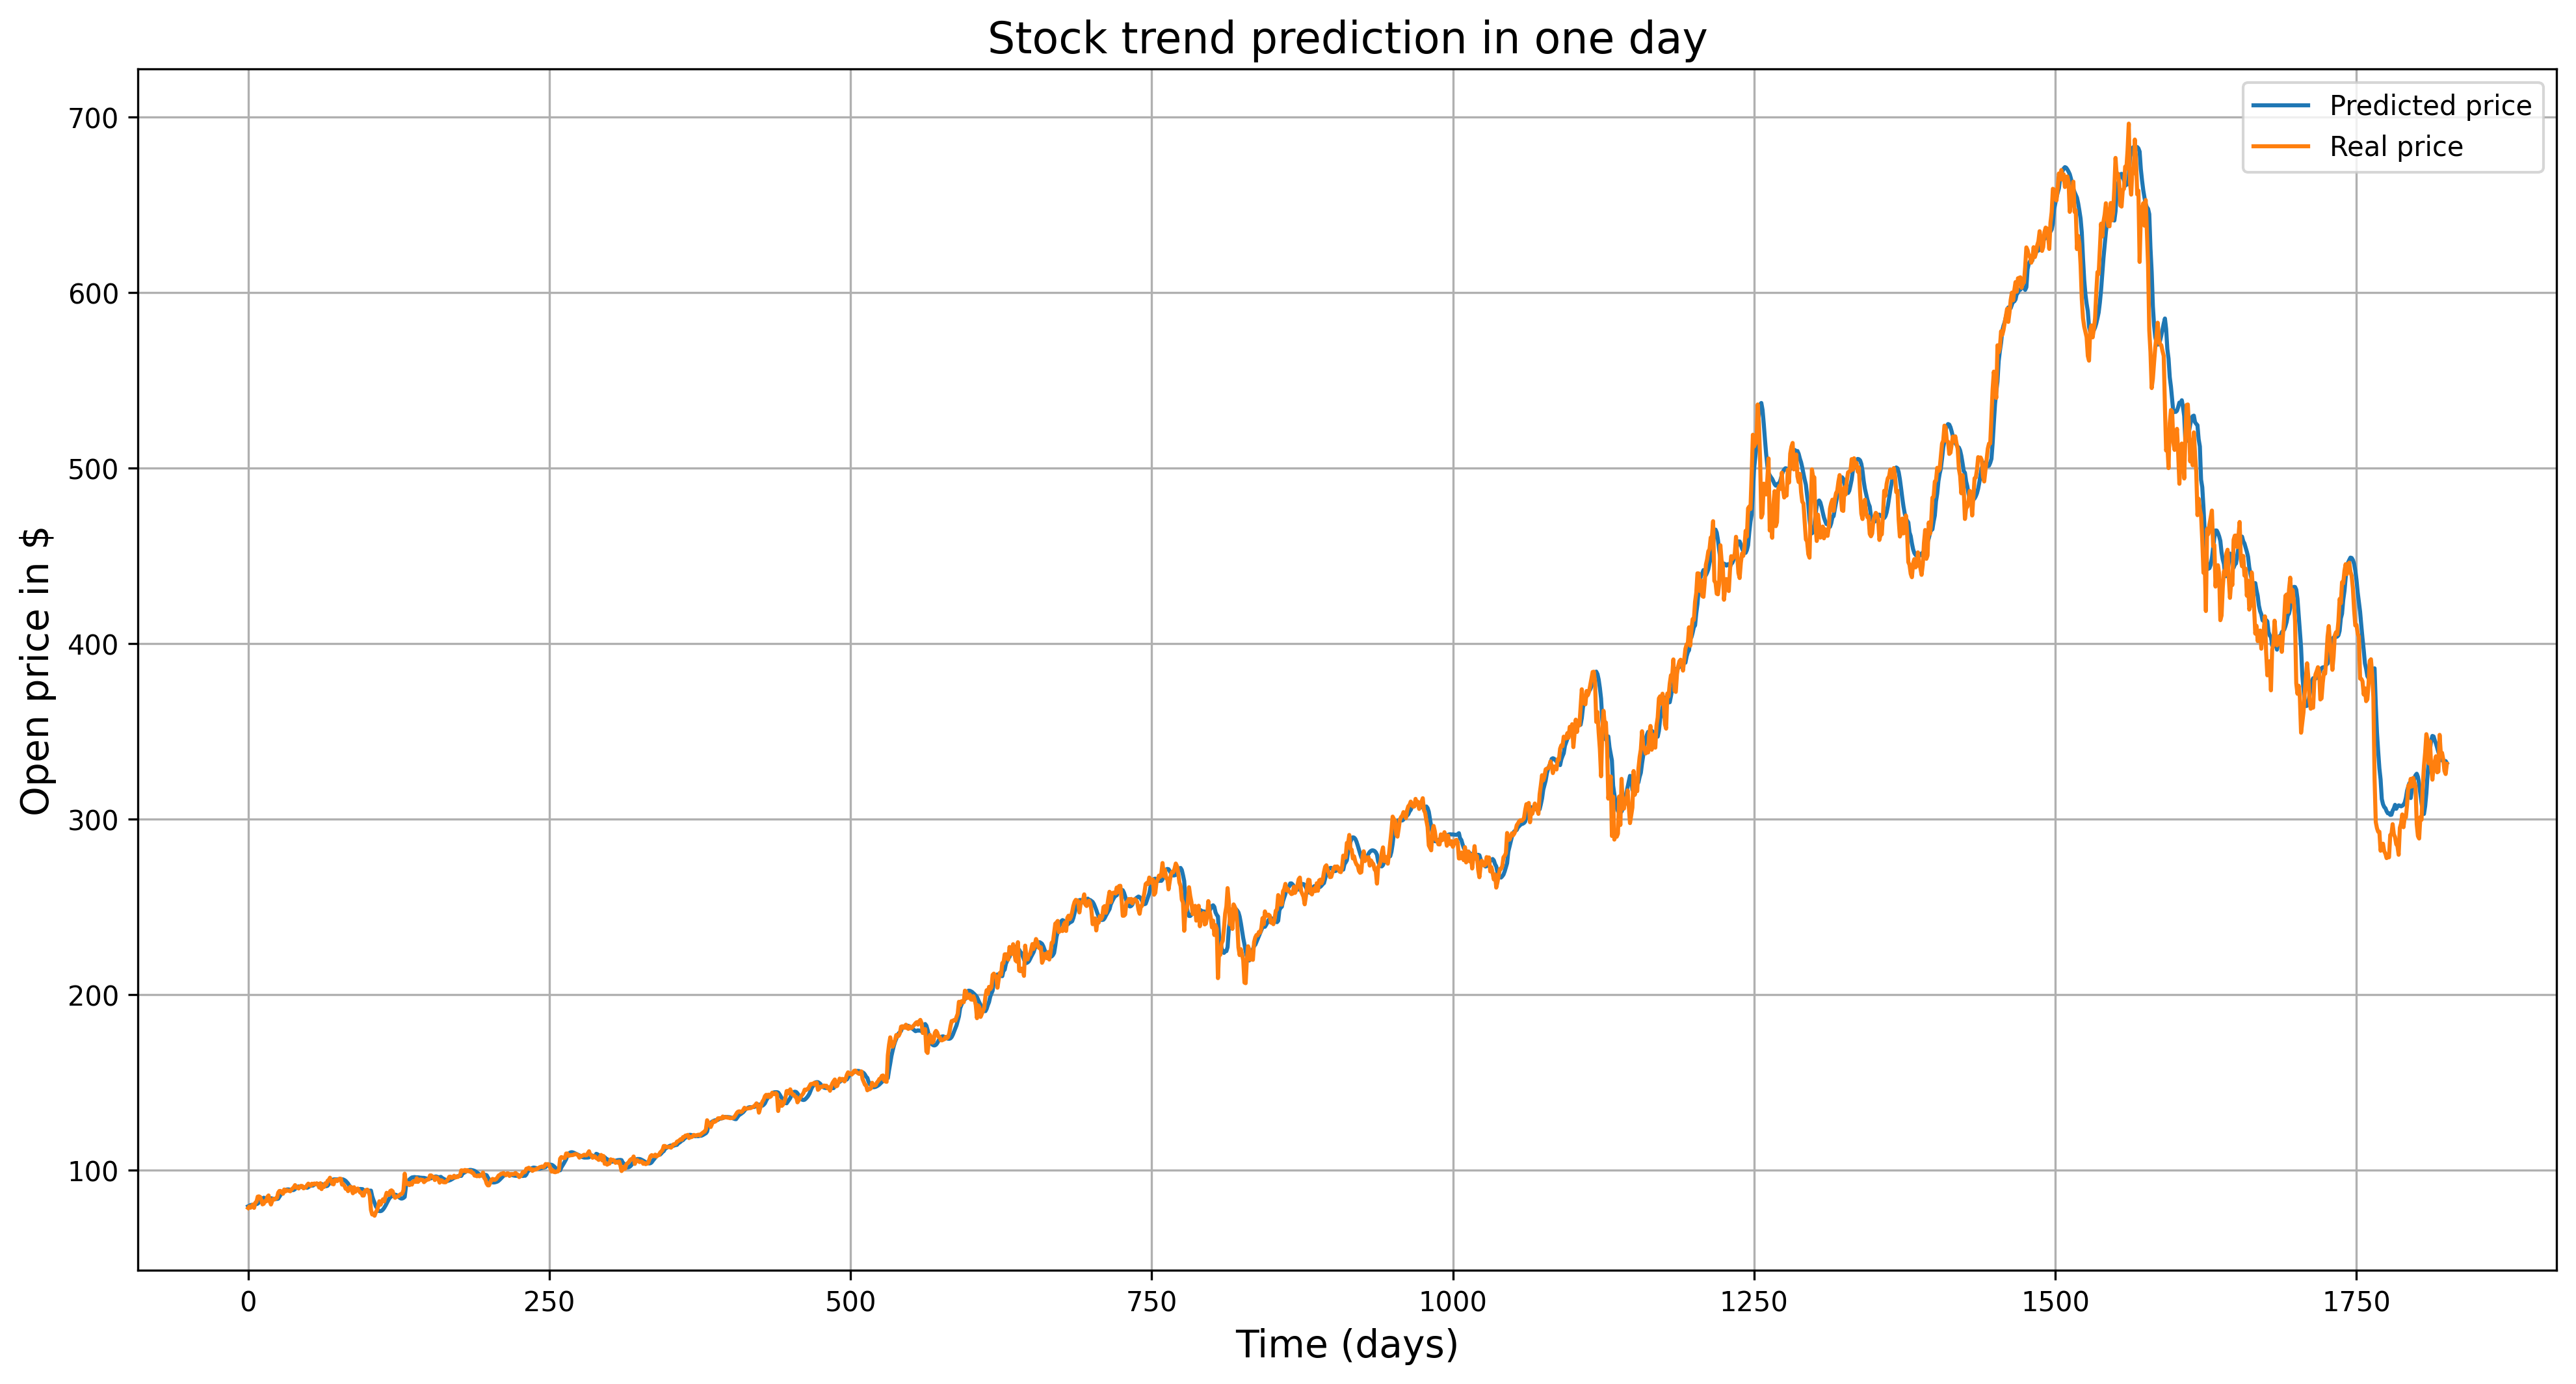

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# MSFT

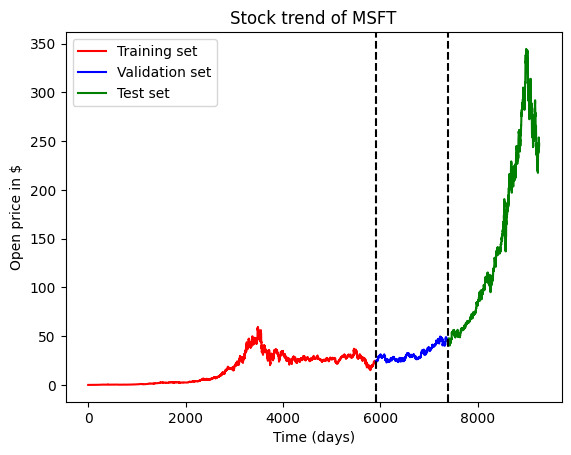

In [ ]:
X_data, y_data = prepare_data(data_msft, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_msft['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of MSFT")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5
12/12 [==============================] - 7s 265ms/step - loss: 0.3870 - mse: 0.3870 - val_loss: 0.2111 - val_mse: 0.2111
Epoch 2/5
12/12 [==============================] - 3s 275ms/step - loss: 0.1483 - mse: 0.1483 - val_loss: 0.1012 - val_mse: 0.1012
Epoch 3/5
12/12 [==============================] - 3s 216ms/step - loss: 0.0889 - mse: 0.0889 - val_loss: 0.0848 - val_mse: 0.0848
Epoch 4/5
12/12 [==============================] - 3s 214ms/step - loss: 0.0749 - mse: 0.0749 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 5/5
12/12 [==============================] - 3s 212ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 0.0542 - val_mse: 0.0542


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

58/58 [==============================] - 1s 11ms/step
MSE on the test set:  0.056034612867824955


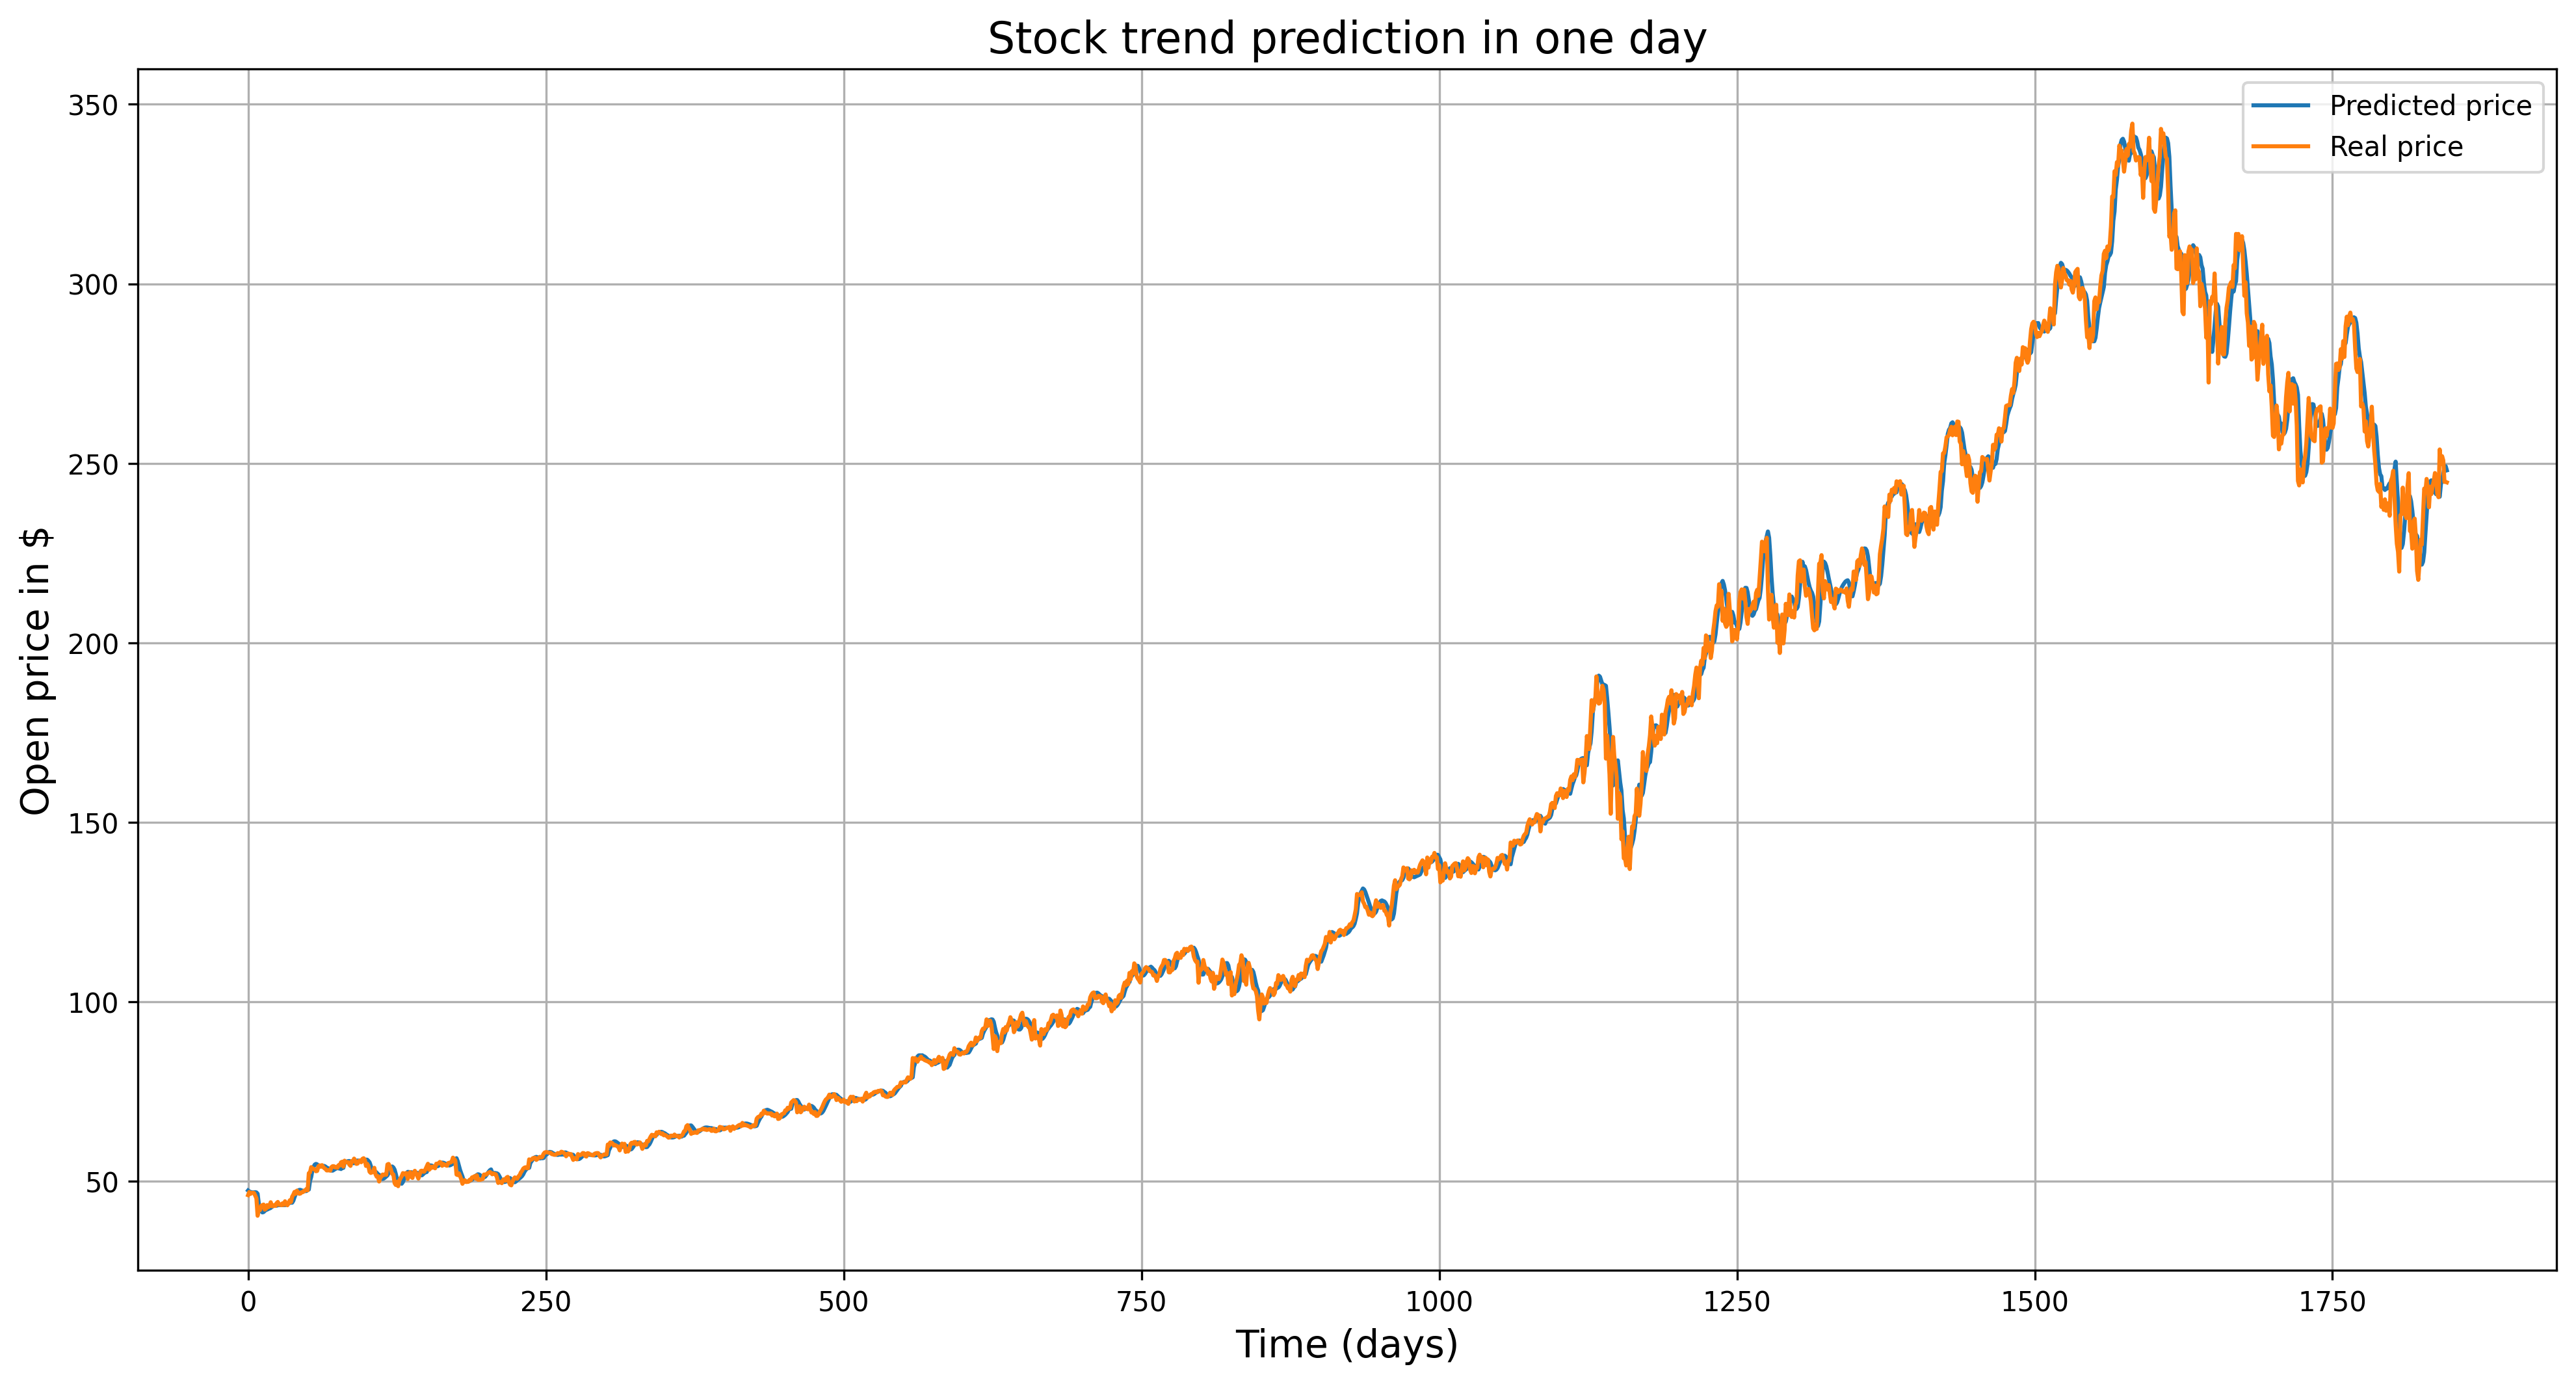

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# AMZN

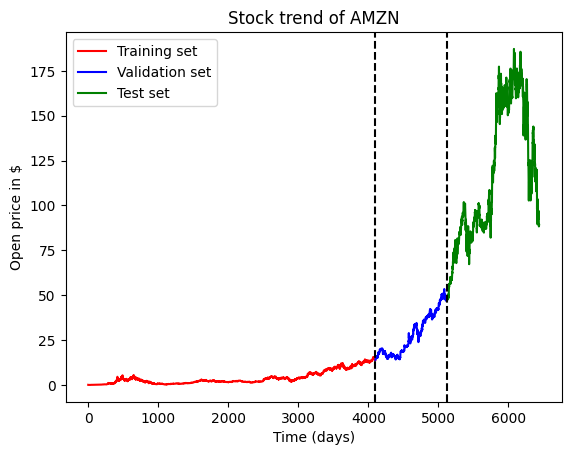

In [ ]:
X_data, y_data = prepare_data(data_amzn, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_amzn['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of AMZN")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5
9/9 [==============================] - 6s 268ms/step - loss: 1.9659 - mse: 1.9659 - val_loss: 0.2334 - val_mse: 0.2334
Epoch 2/5
9/9 [==============================] - 3s 296ms/step - loss: 0.1967 - mse: 0.1967 - val_loss: 0.1689 - val_mse: 0.1689
Epoch 3/5
9/9 [==============================] - 2s 205ms/step - loss: 0.1468 - mse: 0.1468 - val_loss: 0.1524 - val_mse: 0.1524
Epoch 4/5
9/9 [==============================] - 2s 185ms/step - loss: 0.1173 - mse: 0.1173 - val_loss: 0.1026 - val_mse: 0.1026
Epoch 5/5
9/9 [==============================] - 2s 209ms/step - loss: 0.0984 - mse: 0.0984 - val_loss: 0.0979 - val_mse: 0.0979


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

41/41 [==============================] - 1s 10ms/step
MSE on the test set:  0.08044731503221365


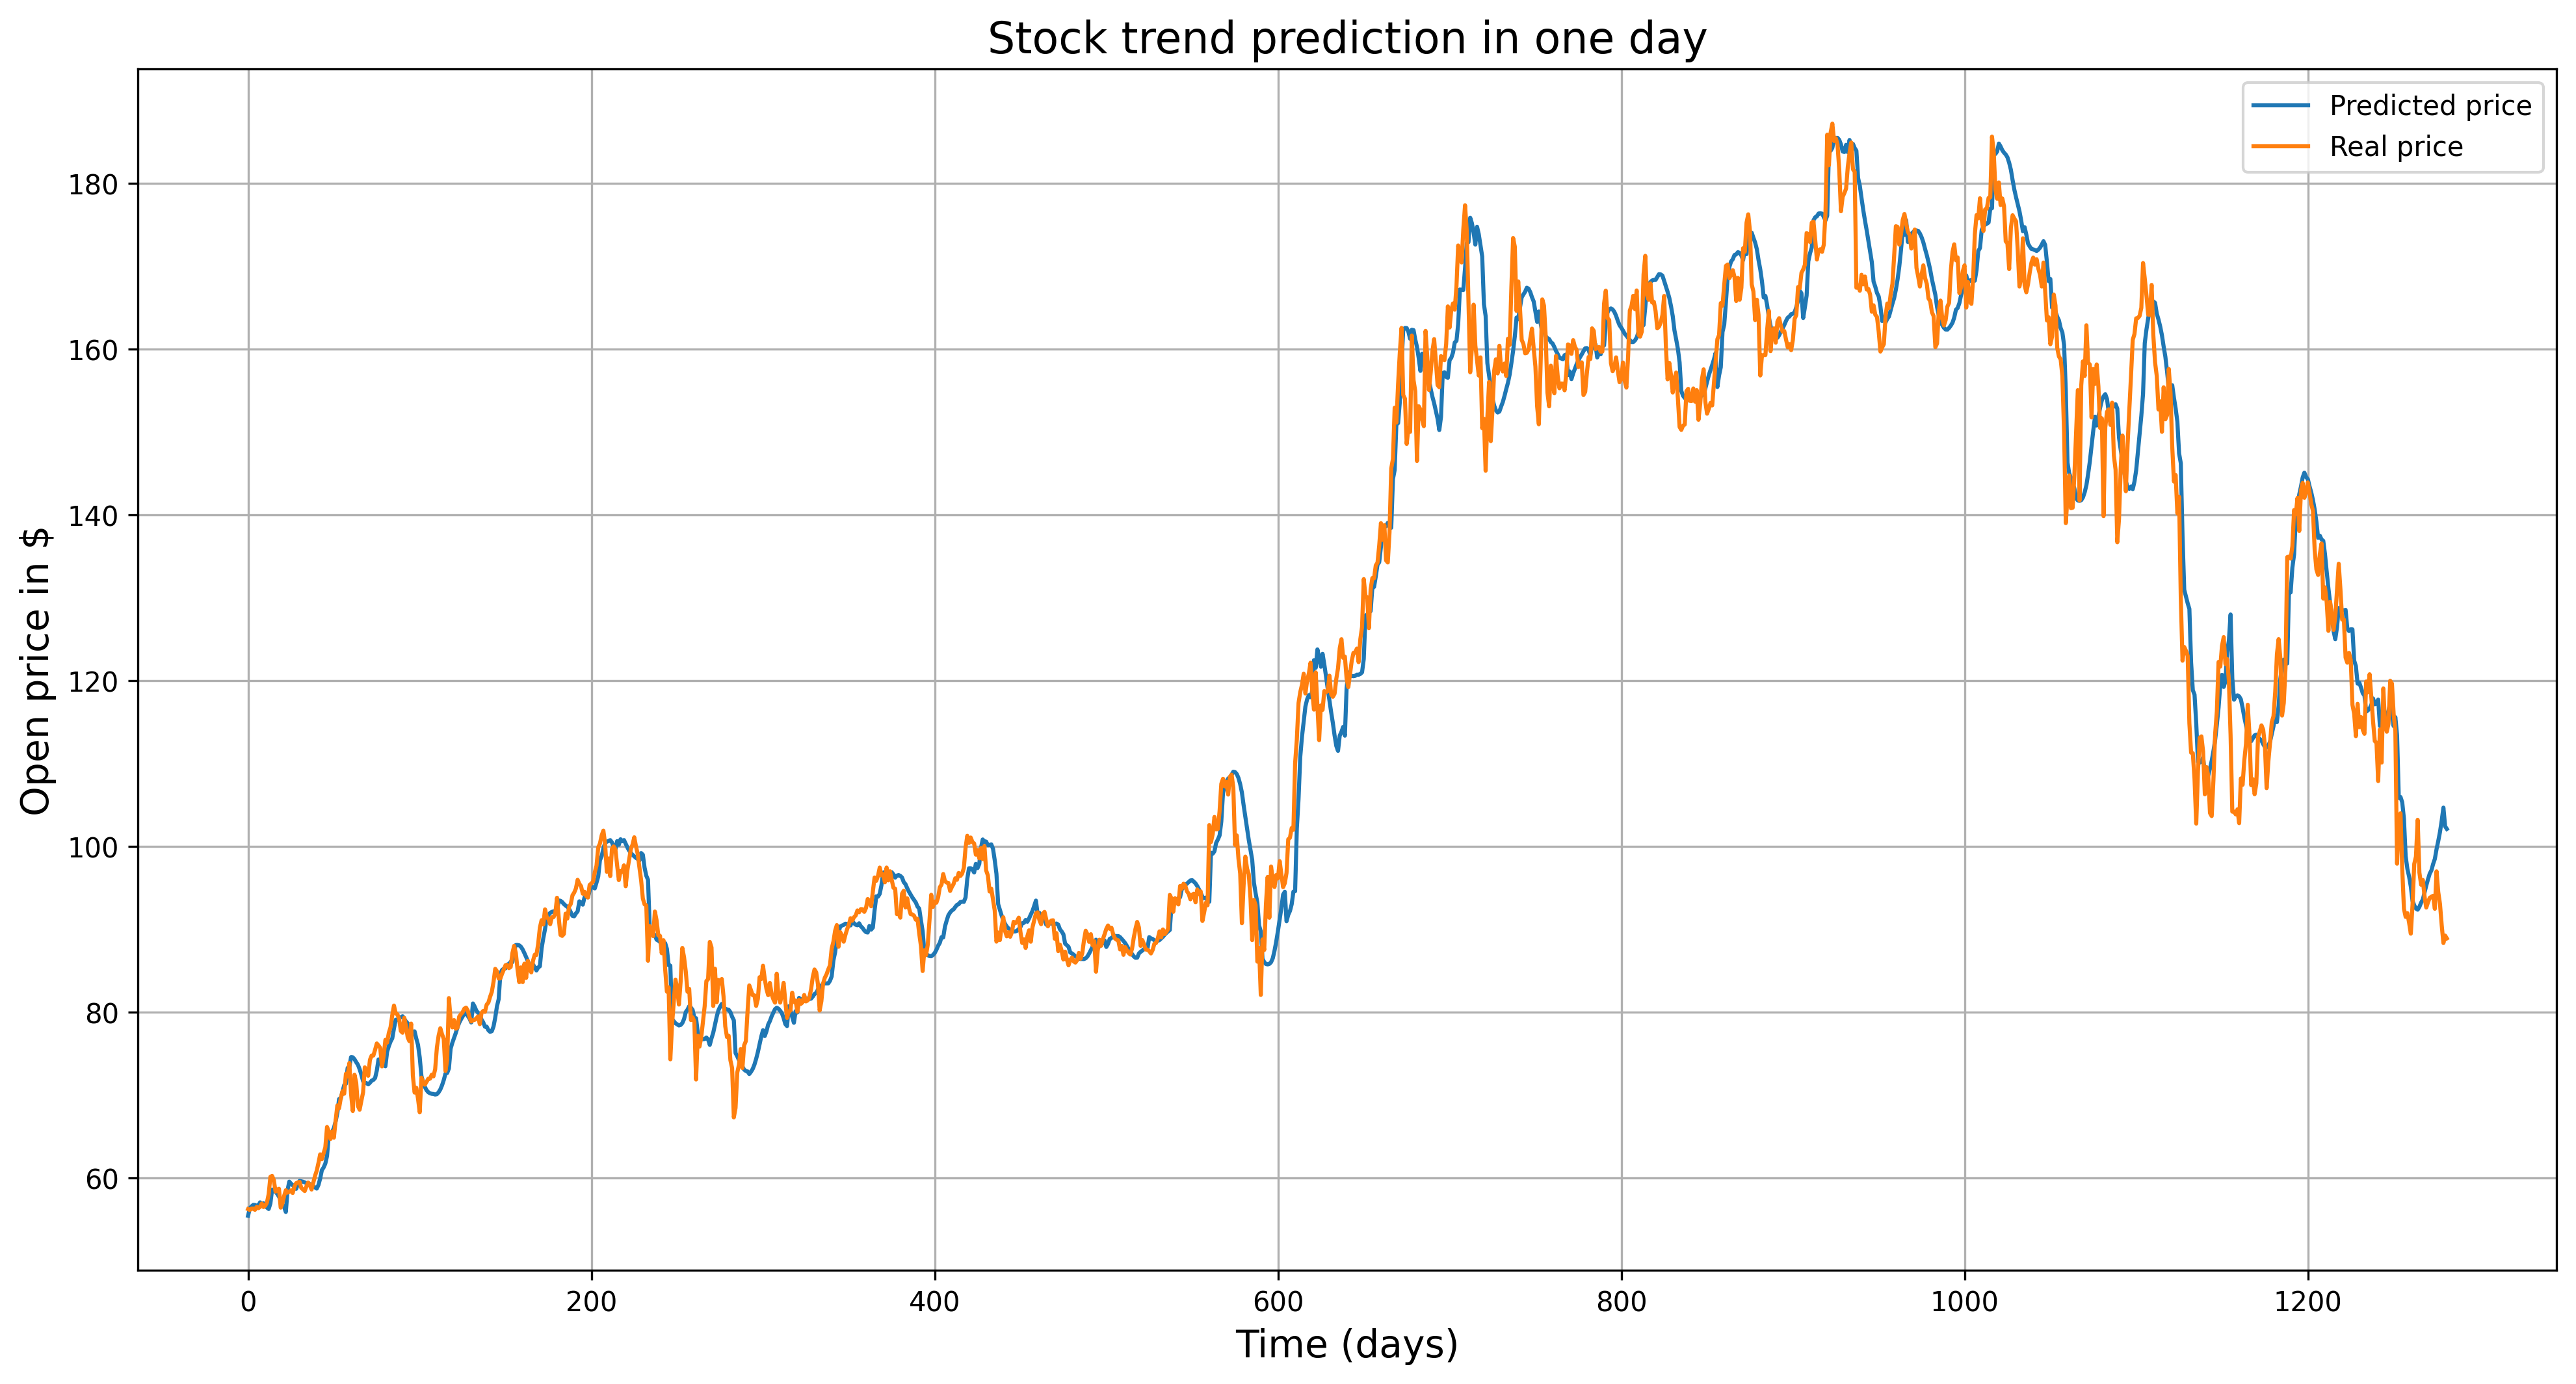

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# NFLX

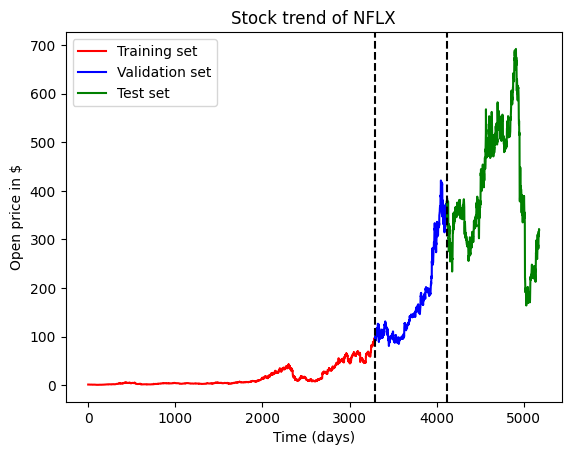

In [ ]:
X_data, y_data = prepare_data(data_nflx, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_nflx['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of NFLX")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()


In [ ]:
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5
7/7 [==============================] - 6s 335ms/step - loss: 0.4102 - mse: 0.4102 - val_loss: 0.1549 - val_mse: 0.1549
Epoch 2/5
7/7 [==============================] - 1s 206ms/step - loss: 0.1662 - mse: 0.1662 - val_loss: 0.1161 - val_mse: 0.1161
Epoch 3/5
7/7 [==============================] - 2s 291ms/step - loss: 0.1202 - mse: 0.1202 - val_loss: 0.0956 - val_mse: 0.0956
Epoch 4/5
7/7 [==============================] - 2s 226ms/step - loss: 0.1081 - mse: 0.1081 - val_loss: 0.0980 - val_mse: 0.0980
Epoch 5/5
7/7 [==============================] - 2s 231ms/step - loss: 0.1010 - mse: 0.1010 - val_loss: 0.0931 - val_mse: 0.0931


33/33 [==============================] - 1s 13ms/step
MSE on the test set:  0.09366720626080591


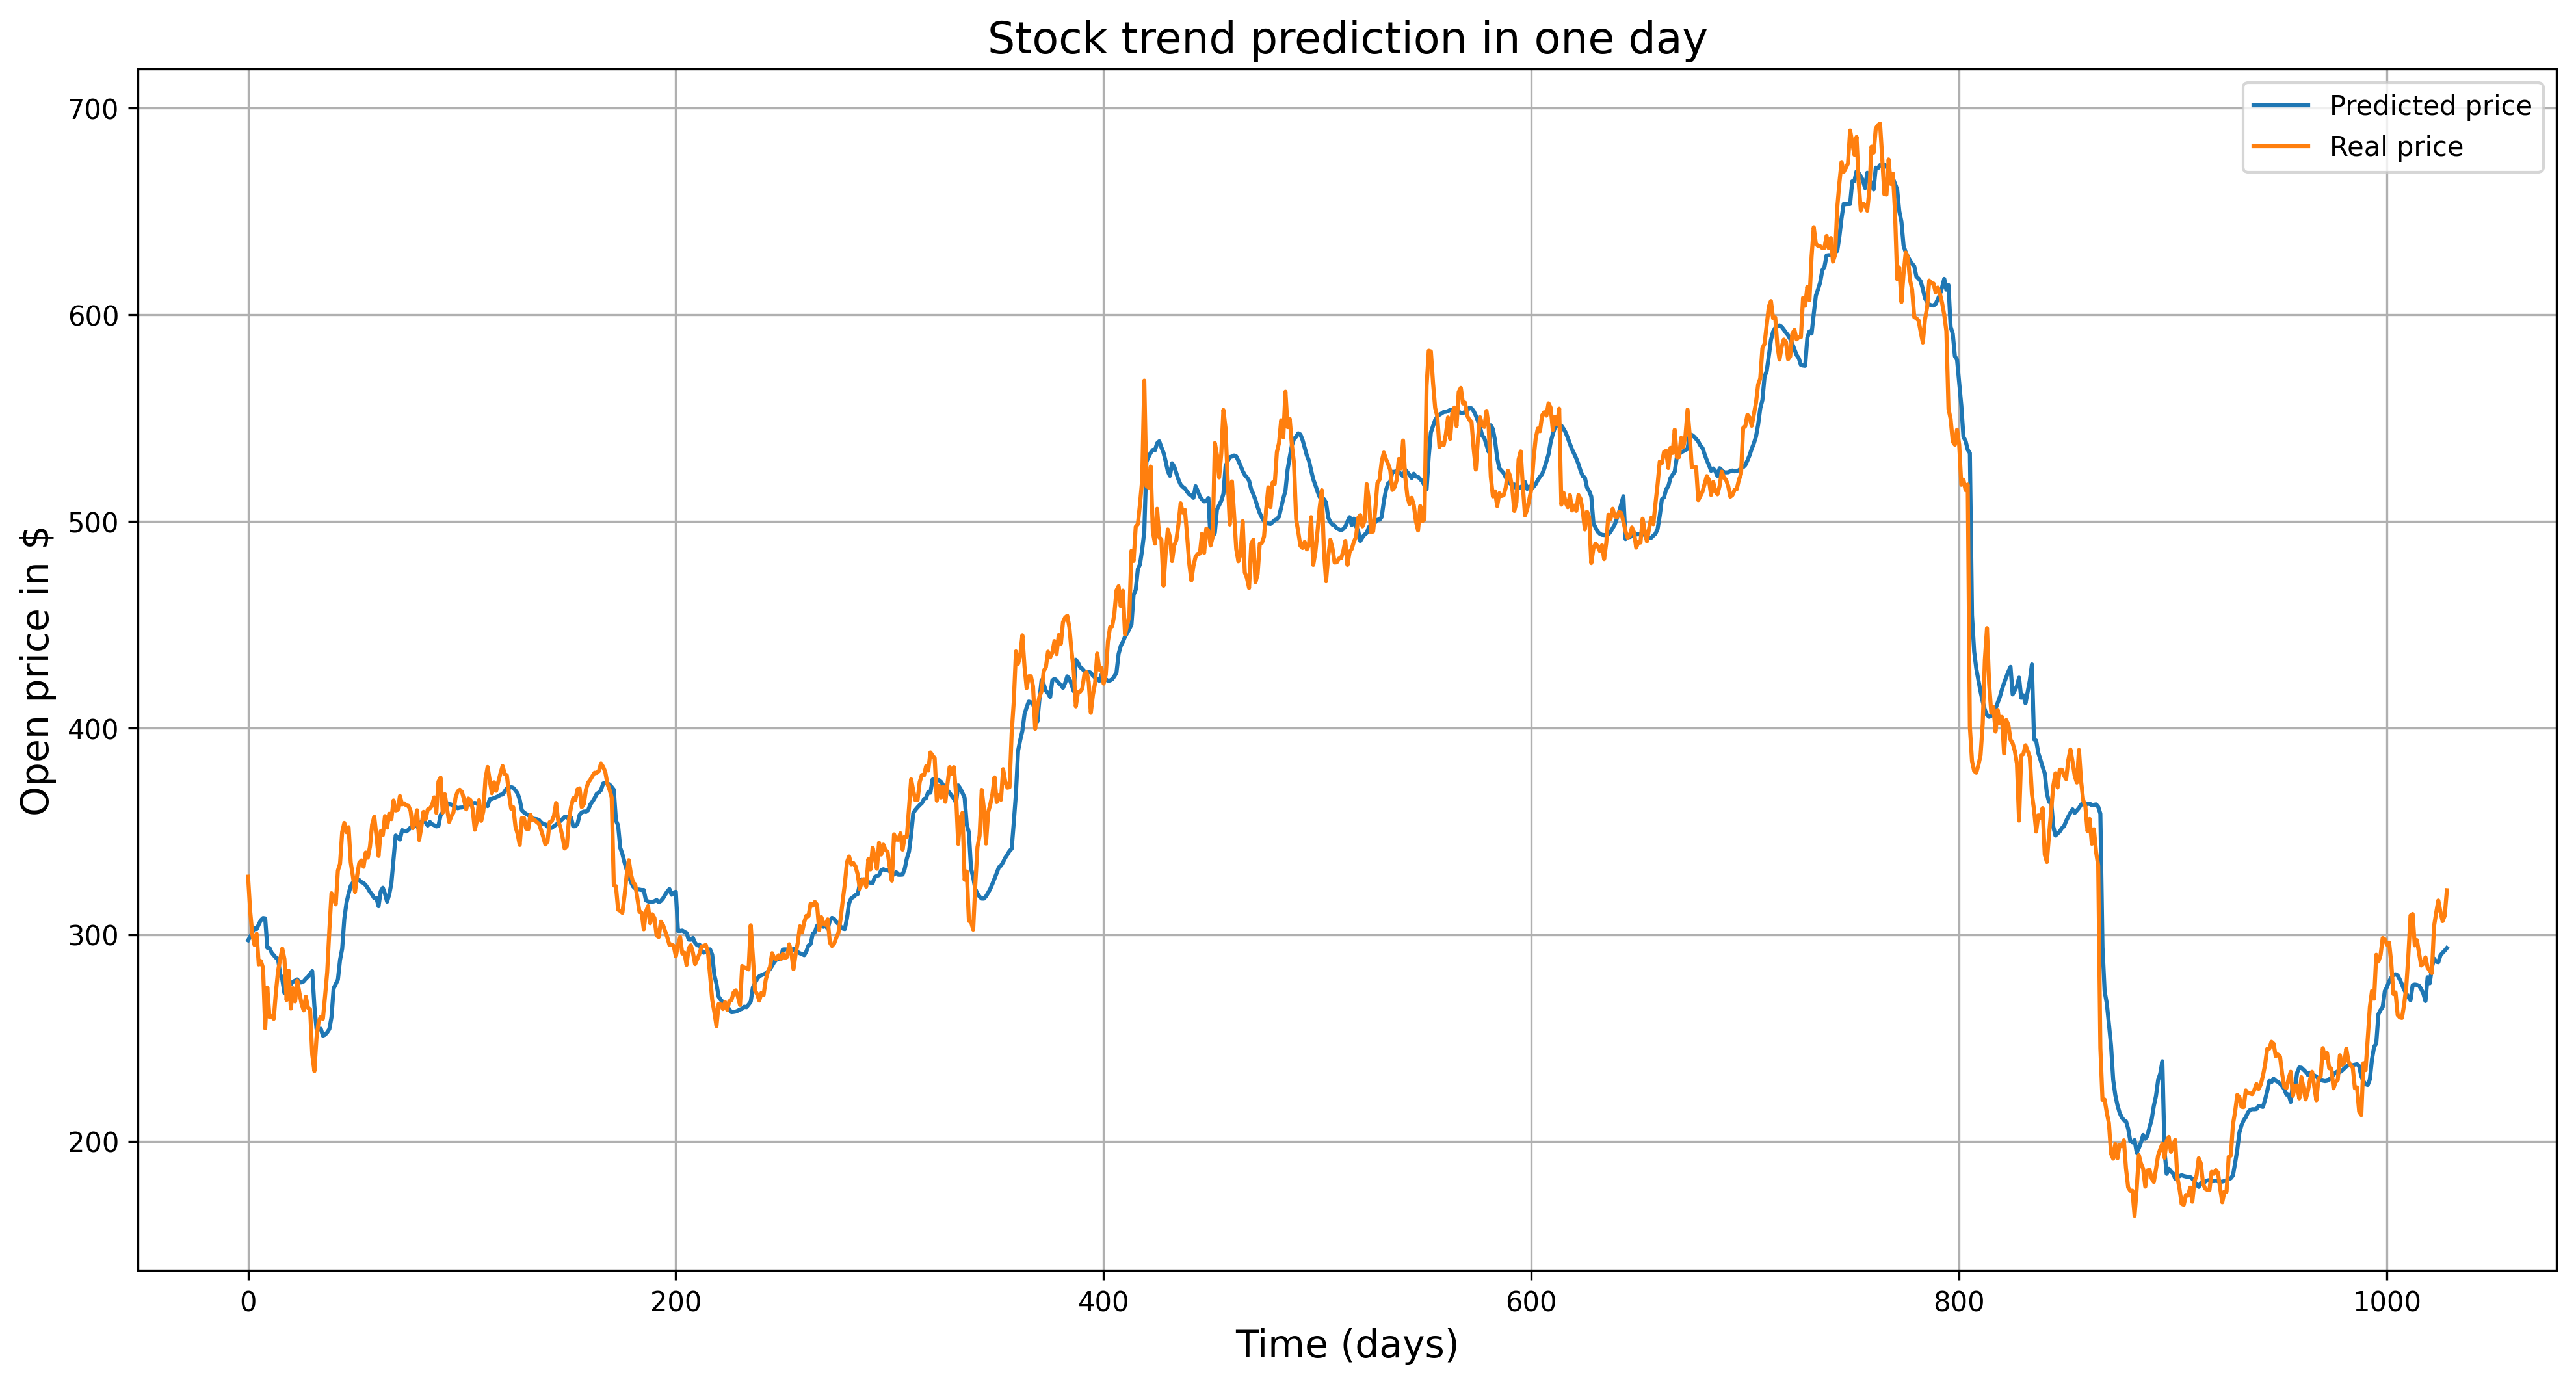

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# VIETNAM

In [ ]:
pip install vnstock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data_fpt = pd.read_csv('FPT-VNINDEX-History.csv')

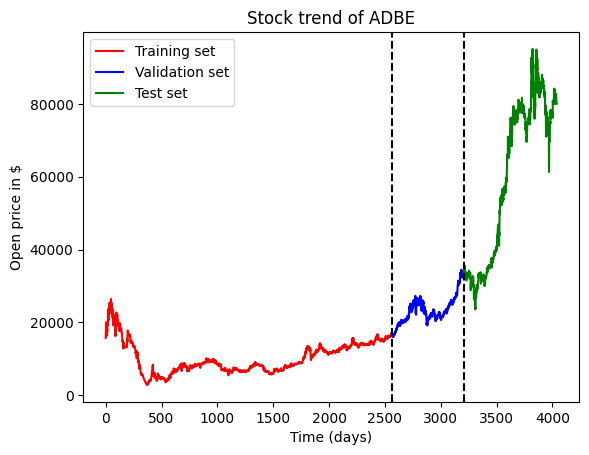

In [ ]:
X_data, y_data = prepare_data(data_fpt, window_size)
# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)
# Visualize the training, validation and test set
df_plot = data_fpt['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of ADBE")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()
X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize_data(X_train, y_train, X_val, y_val)

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units = 50, input_shape = (window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True, activation = "relu")) # By default: activation='linear', i.e., passing through f(x) = x
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=5, batch_size=512)

Epoch 1/5
6/6 [==============================] - 8s 513ms/step - loss: 0.5413 - mse: 0.5413 - val_loss: 0.4160 - val_mse: 0.4160
Epoch 2/5
6/6 [==============================] - 1s 211ms/step - loss: 0.3160 - mse: 0.3160 - val_loss: 0.3411 - val_mse: 0.3411
Epoch 3/5
6/6 [==============================] - 1s 216ms/step - loss: 0.2008 - mse: 0.2008 - val_loss: 0.1313 - val_mse: 0.1313
Epoch 4/5
6/6 [==============================] - 1s 216ms/step - loss: 0.1652 - mse: 0.1652 - val_loss: 0.1601 - val_mse: 0.1601
Epoch 5/5
6/6 [==============================] - 1s 218ms/step - loss: 0.1137 - mse: 0.1137 - val_loss: 0.0889 - val_mse: 0.0889


In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

26/26 [==============================] - 1s 16ms/step
MSE on the test set:  0.09780127573884881


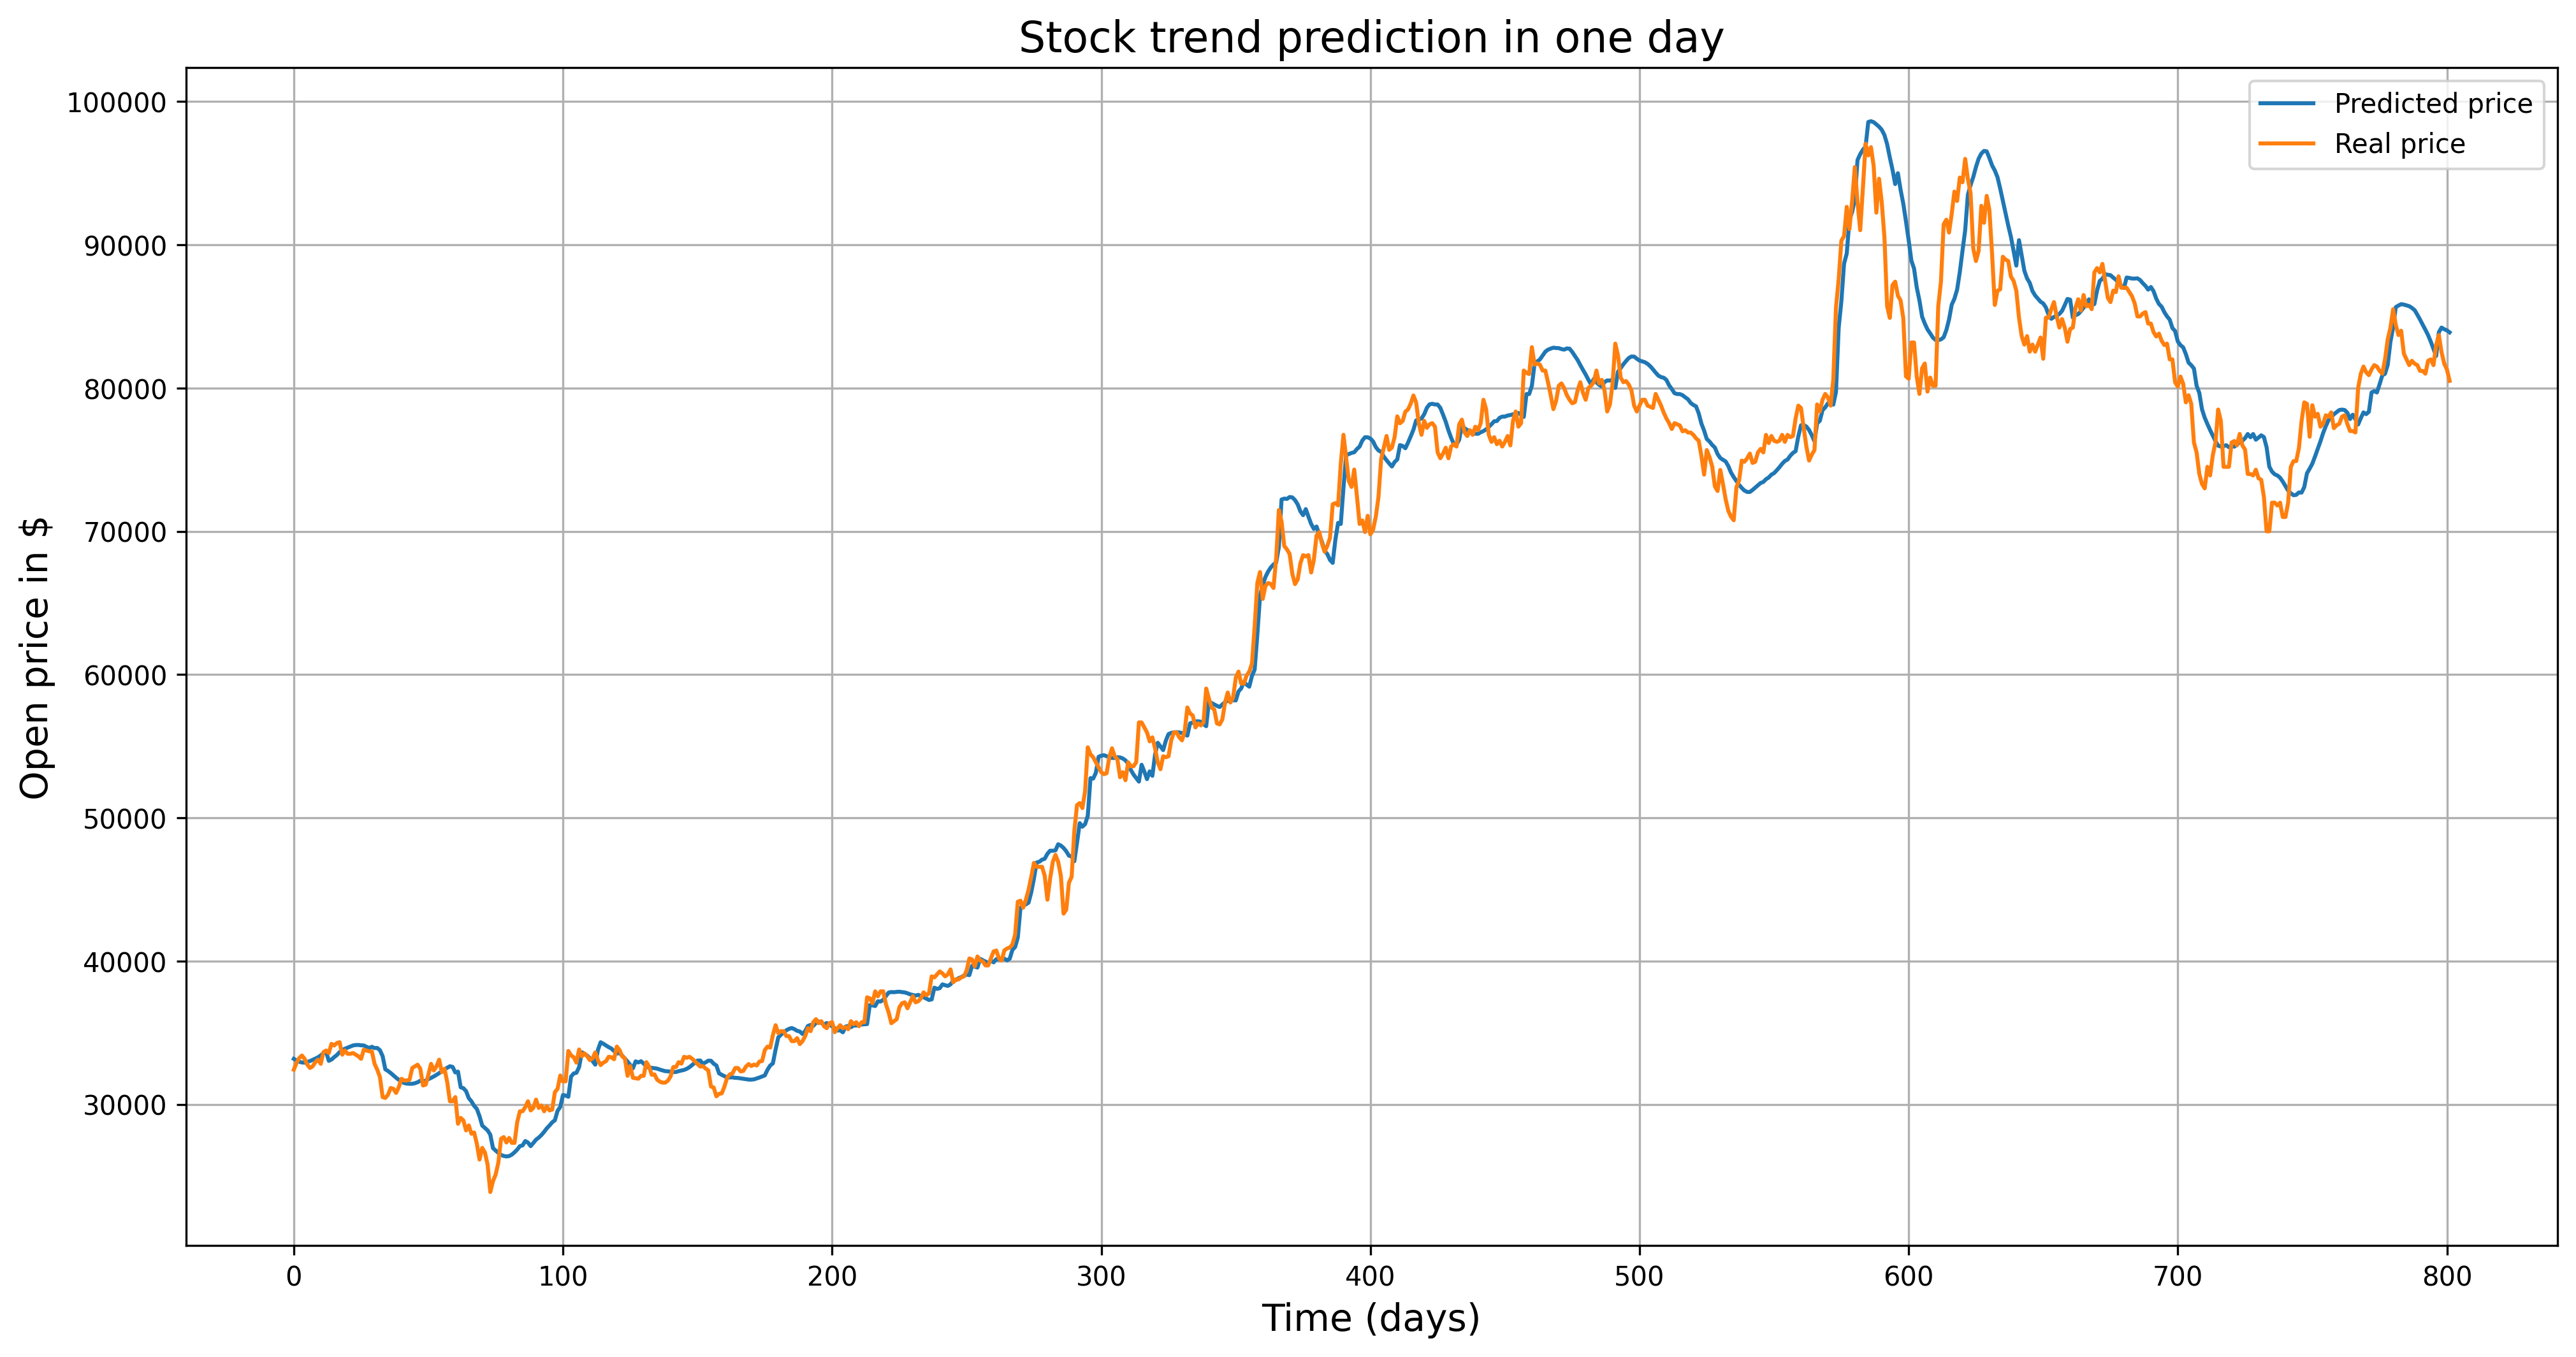

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()